## Cats vs. Dogs ##
In this project our objective will be distinguishing between images of cats and images of dogs.

Kaggle link: https://www.kaggle.com/competitions/dogs-vs-cats/overview

### Preparing the Data ###

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import os, cv2
import numpy as np

# dog = 0, cat = 1
def LoadAnimals(directory, clustering=0):
    x = []
    y = []

    for filename in os.listdir(directory):
        if 'dog' in filename:
            animal_class = 0
        else: # cat
            animal_class = 1

        f = os.path.join(directory, filename)
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)

        if clustering != 0:
            reshaped_image = image.reshape(-1, 3)
            kmeans = KMeans(n_clusters=clustering).fit(reshaped_image)
            segmented_img = kmeans.cluster_centers_[kmeans.labels_]
            segmented_img = segmented_img.reshape(image.shape)
            image = segmented_img

        x.append(np.concatenate(image)) # sklearn doesn't like 3d arrays (x_train is an array of 2d arrays -> 3d array). Transforms 3d array to 2d.
        y.append(animal_class)

    return x, y

In [5]:
x, y = LoadAnimals(r"C:\Users\royha\Documents\Uni\SimData\cats-vs-dogs\train-resized", clustering=0)

### PCA Preparation ###

In [6]:
import pandas as pd

In [7]:
df = pd.DataFrame(np.array(x))
df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,168,173,177,180,185,188,190,193,197,198,...,3,3,3,2,2,2,2,2,2,2
1,43,43,44,43,52,32,52,37,40,61,...,47,50,48,50,55,61,63,89,18,35
2,39,25,42,52,45,55,61,55,54,58,...,157,157,149,134,129,149,159,168,171,153
3,220,224,223,227,229,223,226,235,229,226,...,229,213,206,204,202,214,222,215,212,213
4,117,117,122,92,78,97,134,130,150,180,...,95,95,95,91,101,121,96,90,93,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,140,142,143,145,146,147,148,149,148,149,...,164,165,166,166,167,168,168,168,168,169
24996,119,77,103,84,99,114,71,82,85,87,...,95,94,80,98,86,77,85,94,92,76
24997,42,35,47,56,66,48,48,57,59,39,...,102,135,135,123,71,116,180,127,114,167
24998,253,250,246,234,223,208,187,145,114,73,...,120,101,106,112,112,112,106,118,115,119


We'll make a graph that will help us understand which n_components is the most optimal for us and why

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_10000 = PCA(n_components=10000)
pca_10000.fit(df)

plt.grid()
plt.plot(np.cumsum(pca_10000.explained_variance_ratio_ * 1000))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

According to the graph, it seems that n_components = 1000 is the best fit in our opinion. It keeps about 94% of the variance, hence we only lose a small amount of data, in exchange to increasing the time efficiency by alot. That is since we reduced 9000 dimensions.

In [8]:
from sklearn.decomposition import PCA

pca_1000 = PCA(n_components=1000)
pca_1000.fit(df)

PCA(n_components=1000)

We'll calculate the exact explained variance for n=1000

In [9]:
np.cumsum(pca_1000.explained_variance_ratio_ * 100)[-1]

94.3087122277318

Now we'll use the new data with reduced dimensions

In [10]:
transformed_x = pca_1000.fit_transform(x)

## Analyzing Feature Importance ##
Using Random Forest.

In [11]:
def array1dto2d(arr, w, h):
    if w*h != len(arr):
        return None
    else:
        ret = []
        for i in range(0, h):
            ret.append( arr[w*i:w*(i+1)] )
        return ret

In [12]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib.colors import ListedColormap

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(x, y)

impprtances = array1dto2d(rnd_clf.feature_importances_, 100, 100)

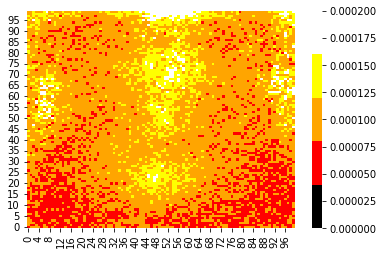

In [21]:
import matplotlib.pyplot as plt

sns.heatmap(impprtances, vmin=0, vmax=0.0002, cmap=ListedColormap(['black', 'red', 'orange', 'yellow', 'white']))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

Conclusion: It seems our pictures don't have a pattern and a specific area in which the important (or non-important, a dead space such the top right corner commonly being a wall) information is.

# Models #

In [22]:
from sklearn.model_selection import cross_val_score

def Test(name, model, new_x=x, new_y=y, new_cv=30, print_flag=True, return_flag=False):
    score = abs(np.median( cross_val_score(model, new_x, new_y, cv=new_cv, scoring='accuracy') ))
    if print_flag:
        print('{}: {}'.format(name, score))
    if return_flag:
        return score

First we will run a dummy to set our baseline.

In [25]:
from sklearn.dummy import DummyClassifier
Test('Dummy (stratified)', DummyClassifier(strategy="stratified"))
Test('Dummy (most_frequent)', DummyClassifier(strategy="most_frequent"))

Dummy (stratified): 0.4969987995198079
Dummy (most_frequent): 0.49939975990396157


Next we will try multiple models, to increase our accuracy using Voting classifier.

In [26]:
from sklearn.linear_model import LogisticRegression
Test('Logistic Regression', LogisticRegression())

Logistic Regression: 0.5458000000000001


In [24]:
from sklearn.ensemble import RandomForestClassifier
Test('Random Forest', RandomForestClassifier())

Random Forest: 0.5932


Lets try some new models: AdaBoost, XGBoost.

In [27]:
from xgboost import XGBClassifier
Test('XGBoost', XGBClassifier())

XGBoost: 0.625


In [26]:
from sklearn.ensemble import AdaBoostClassifier
Test('AdaBoost', AdaBoostClassifier())

AdaBoost: 0.6118


Finding optimal K for KNN by trying values of K:

In [28]:
from sklearn.neighbors import KNeighborsClassifier

best_score = (0,0)
for k in range(0, 21):
    score = Test('KNN', KNeighborsClassifier(n_neighbors=k), new_x=transformed_x, print_flag=False, return_flag=True)
    if score > best_score[1]:
        best_score = (k, score)

print('KNN (best k {}): {}'.format(best_score[0], best_score[1]))

KNN (best k 17): 0.6038415366146459


In [9]:
from sklearn.svm import SVC
Test('SVC', SVC())

SVC: 0.6608


We tried running Bagging with Random Forest, and it was not successful. 1% Boost in accuracy, however it is 4 times longer.

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
bagging = BaggingClassifier(RandomForestClassifier(), n_estimators=10, max_samples=12500)
Test('Bagging Classifier', bagging)

Bagging Classifier: 0.6024


In [16]:
from sklearn.naive_bayes import GaussianNB
Test('GaussianNB', GaussianNB())

GaussianNB: 0.5684


Dummy (stratified): 0.4969987995198079 <br>
Dummy (most_frequent): 0.49939975990396157 <br>
<br>
LogisticRegression: 55 <br>
RandomForestClassifier: 59 <br>
XGBClassifier: 63 <br>
Adaboost: 61 <br>
KNN(k=17): 60 <br>
SVC: 66 <br>
GaussianNB: 57

We decided to run Hard Voting on all the models that have 60% or more accuracy.

In [29]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

estimators = [  ("svc", SVC()),
                ("XGB",XGBClassifier()),
                ("AdaB",AdaBoostClassifier()),
                ("KNN",KNeighborsClassifier(n_neighbors=17))]

ensemble = VotingClassifier(estimators)

Test("HardVoting", ensemble, new_cv=5)

HardVoting: 68.291


### Final Test ###

In [30]:
x_test, y_test = LoadAnimals(r"C:\Users\royha\Documents\Uni\SimData\cats-vs-dogs\test-resized", clustering=0)

estimators = [  ("svc", SVC()),
                ("XGB",XGBClassifier()),
                ("AdaB",AdaBoostClassifier()),
                ("KNN",KNeighborsClassifier(n_neighbors=17))]

ensemble = VotingClassifier(estimators)
ensemble.fit(x, y)

In [ ]:
ensemble.score(x_test, y_test)